In [1]:
from config import *
from pyfeats import glcm_features
from torchstain import MacenkoNormalizer
from utils import *
from scipy.ndimage.morphology import distance_transform_edt

normalizer = MacenkoNormalizer(backend='numpy')
normalizer.HERef = np.array([[0.47262014, 0.17700575],
                             [0.79697804, 0.84033483],
                             [0.37610664, 0.51235373]])
normalizer.maxCRef = np.array([1.43072807, 0.98501085])


/home/ahabis/.local/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/tmp/ipykernel_402562/1253417915.py:5: DeprecationWarning: Please use `distance_transform_edt` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import distance_transform_edt


In [103]:
ann = pd.read_csv(os.path.join(path_annotations,'annotations.csv'), index_col=0)
x = 2
y = 15
features = []
all_correlograms = []
for filename in os.listdir(path_images):
    mask  = tifffile.imread(os.path.join(path_masks,filename))
    image = tifffile.imread(os.path.join(path_images,filename))
    img, HE  = normalizer.normalize(image)
    HE_corr = np.clip(HE.reshape(2,image.shape[0], image.shape[1])[1],0,5)/5
    HE = (255 * HE_corr).astype(int)
    all_correlograms.append(compute_correlogram(HE_corr,mask,x,y))
    # features.append(glcm_features(HE,ignore_zeros=True)[1])


In [104]:
correlograms_stack = np.stack(all_correlograms)

In [113]:
def compute_correlogram(img,
                        mask,
                        bins_space,
                        bins_digit_size):
    
    
    corr = np.zeros((bins_space, bins_digit_size))
    itf = distance_transform_edt(mask)
    itf = itf/np.max(itf)
    lin = np.arange(0,1 + bins_space,1/bins_space)
    lin2 = np.linspace(0,1,bins_digit_size+1)
    
    for i in range(bins_space):
        levels = np.logical_and(itf >(i/bins_space), itf<((i+1)/bins_space))

        without_zeros = img * levels
        without_zeros = without_zeros[without_zeros>0.]
        hist,_ = np.histogram(without_zeros, bins = lin2, density=True)
        corr[i] = hist
    return corr

In [114]:
# features_stack = np.stack(features)
# ann = ann.replace(['dilated_tubule', 'fake_tubule'],[1,0])
# dic = {}
# for index, row in ann[ann['image']== '20182.svs'].iterrows():
#     filename = row_to_filename(row)
#     dic[filename] = row.term

In [115]:
matrixes_big = []
vals_big = []

for filename in np.unique(list(ann['image'])):
    ann = ann.replace(['dilated_tubule', 'fake_tubule'],[1,0])
    dic = {}
    for index, row in ann[ann['image']== filename].iterrows():
        filename = row_to_filename(row)
        dic[filename] = row.term

    list_ = list(dic.keys())
    indexes = np.zeros(len(list_))
    for i, filename in enumerate(list_):
        indexes[i] = np.argwhere(np.array(os.listdir(path_images)) == filename).flatten()[0]

    correlograms = correlograms_stack[indexes.astype(int)]
    indexes_1 = np.argwhere(np.array(list(dic.values())) == 1).flatten()
    matrixes = np.zeros((len(indexes_1), correlograms.shape[0]))
    vals = np.tile(np.array(list(dic.values())),len(indexes_1))

    for j, index_anchor in enumerate(indexes_1):
        correlograms_anchor = correlograms[index_anchor][None]
    
        matrixes[j] = np.mean(np.sum(np.minimum(correlograms, correlograms_anchor),-1)/ np.sum(np.maximum(correlograms, correlograms_anchor),-1),axis = -1)
    matrixes_big.append(matrixes.flatten())
    vals_big.append(vals)

In [116]:
data = np.concatenate(matrixes_big)
score= data# score = np.mean(data.reshape((data.shape[0],-1)),-1)
vals = np.concatenate(vals_big)

# from sklearn.linear_model import LinearRegression


# l = LinearRegression(fit_intercept=False,positive = True)
# l.fit(data,vals)
# score = data[:,0]

n_iter = 10000
eps = 1e-8
precision ,recall, recognition, pq  = np.zeros(n_iter), np.zeros(n_iter), np.zeros(n_iter), np.zeros(n_iter)

gt = vals
ts = np.linspace(0,1,n_iter)


for i, t in enumerate(ts):
    
    index_tp = np.argwhere(np.logical_and(score>t, gt.astype('bool'))).flatten()
    tp = np.sum((score>t).astype(int) * gt)
    tn = np.sum((score<t).astype(int) * (1 - gt))
    fp = np.sum((score>t).astype(int) * (1 - gt))
    fn = np.sum((score<t).astype(int) * (gt))
    
    precision[i] =   np.sum(tp) / (np.sum(tp) + np.sum(fp) + eps) 
    recall[i] =   np.sum(tp) / (np.sum(tp) + np.sum(fn) + eps) 
    recognition[i] =   2 * precision[i]*recall[i]/(precision[i]+ recall[i]+eps)


0.8764145324591449
0.6564800356900198
0.7506695525568553


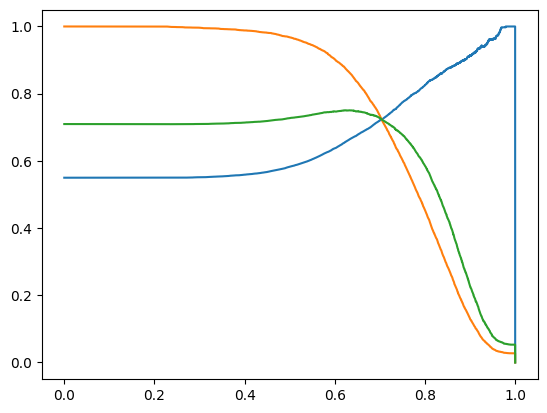

In [117]:
plt.plot(ts,precision)
plt.plot(ts,recall)
plt.plot(ts,recognition)
ind_ = np.argmax(recognition)
print(recall[ind_])
print(precision[ind_])
print(recognition[ind_])


In [110]:
features = features_stack[indexes.astype(int)]
indexes_1 = np.argwhere(np.array(list(dic.values())) == 1).flatten()
matrixes = np.zeros((len(indexes_1), features.shape[0],features.shape[1]))
vals = np.tile(np.array(list(dic.values())),len(indexes_1))
for j, index_anchor in enumerate(indexes_1):
    features_anchor = features[index_anchor][None]
    matrixes[j] = np.minimum(features, features_anchor)/ np.maximum(features, features_anchor)
matrixes
vals

NameError: name 'features_stack' is not defined